# **Install and Import Required Libraries**



*   **Description**:This cell installs the necessary Python packages
(like transformers for the BERT model and datasets for handling data) using pip. It then imports the libraries needed for data manipulation (pandas), math operations (numpy), machine learning metrics (sklearn), and plotting graphs (matplotlib/seaborn).

*   **Observation**: The installation process (!pip install ...) might take 30–60 seconds to complete. You will see a lot of text output during installation. If it runs successfully, you will see the message "Libraries installed and imported" at the bottom.



In [11]:
# Cell 1: Install and Import Required Libraries
!pip install transformers datasets scikit-learn pandas openpyxl -q

import torch
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries installed and imported.")

Libraries installed and imported.


# **Load the Test Dataset**


*   **Description:** This cell attempts to read your Excel file (AMAZON REVIEW RATING.xlsx) into a Pandas DataFrame. It includes a try-except block to handle errors gracefully if you forget to upload the file

*   **Observation:**  it must manually upload the Excel file to the Colab "Files" tab (on the left sidebar) before running this. If successful, you will see the first 5 rows of your data. If it fails, it will print an error asking you to upload the file.


In [12]:
# Cell 2: Load the Test Dataset
try:
    # Make sure 'AMAZON REVIEW RATING.xlsx' is uploaded to the Files section on the left
    df_test = pd.read_excel("AMAZON REVIEW RATING.xlsx")
    print("Successfully loaded test data.")
    display(df_test.head())
except FileNotFoundError:
    print("Error: Test dataset not found. Please upload 'AMAZON REVIEW RATING.xlsx'.")

Successfully loaded test data.


,Rating,Title,Review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


# **Preprocess Test Data**



*   **Description:** This cleans the data. It filters out "neutral" 3-star reviews, keeping only clear Positive (4-5 stars) and Negative (1-2 stars) reviews. It converts the ratings into binary labels (1 for Positive, 0 for Negative) and removes any blank or empty rows.

*   **Observation:**
Check the "Total samples" printout. If this number is zero, it means your Excel file might have different column names (e.g., maybe "Ratings" instead of "Rating"), or the data format is incorrect.



In [13]:
# Cell 3: Preprocess Test Data
# Only ratings 1-2 (negative) and 4-5 (positive), ignore 3
if 'df_test' in locals():
    df_test = df_test[df_test["Rating"].isin([1,2,4,5])].copy()

    # 1 = Positive (4-5 stars), 0 = Negative (1-2 stars)
    df_test["label"] = df_test["Rating"].apply(lambda x: 1 if x >= 4 else 0)

    df_test = df_test.rename(columns={"Review": "text"})

    # Remove empty rows
    df_test = df_test[df_test["text"].str.strip().astype(bool)].reset_index(drop=True)

    test_texts = df_test["text"].tolist()
    test_labels = df_test["label"].tolist()

    print(f"Data processed. Total samples: {len(test_texts)}")
    print(f"Sample text: {test_texts[0]}")
    print(f"Sample label: {test_labels[0]}")
else:
    print("Dataframe not found. Check Cell 2.")

Data processed. Total samples: 4012
Sample text: I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature.
Sample label: 1


# **Tokenization**

*   **Description:**
This initializes the Tokenizer, which converts your text reviews into numbers (tokens) that the AI model can understand. It creates a custom ReviewDataset class that formats the data specifically for PyTorch.
*   **Observation:**
We are using the distilbert-base-uncased-finetuned-sst-2-english model name here. The tokenizer will automatically truncate long reviews to fit the model's limit (usually 512 tokens). This prevents errors with very long paragraphs.



In [14]:
# Cell 4: Tokenization

# UPDATED: We use a model already fine-tuned for sentiment analysis (SST-2)
# If you have a custom saved model, replace the string below with your folder path
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'

print(f"Loading tokenizer for: {MODEL_NAME}...")
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

test_encodings = tokenizer(test_texts, truncation=True, padding=True)

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

test_dataset = ReviewDataset(test_encodings, test_labels)
print("Tokenization complete.")

Loading tokenizer for: distilbert-base-uncased-finetuned-sst-2-english...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Tokenization complete.


# **Load the Best Model**



*   **Description:**
This loads the pre-trained DistilBERT model from the Hugging Face Hub. It moves the model to the GPU (cuda) if Colab has provided one, which makes calculations much faster.
*   **Observation:**
Look at the output message. If it says "Model loaded successfully on cuda", your predictions will be very fast. If it says "cpu", the next step will take significantly longer.



In [15]:
# Cell 5: Load the Model
print(f"Loading model: {MODEL_NAME}...")

# This uses the MODEL_NAME defined in Cell 4
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"Model loaded successfully on {device}.")

Loading model: distilbert-base-uncased-finetuned-sst-2-english...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model loaded successfully on cuda.


# **Run Predictions**

*   **Description:**
This is the inference loop. It feeds the tokenized data into the model in batches of 16. The model outputs "logits" (raw scores), which are converted into predictions (0 or 1) using argmax.
*   **Observation:**
torch.no_grad() is used here to disable gradient calculation, which saves memory and speeds up the process since we are testing, not training. Depending on your dataset size, this might take a few seconds to a few minutes.



In [16]:
predictions = []
true_labels = []
with torch.no_grad():
    for batch in torch.utils.data.DataLoader(test_dataset, batch_size=16):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# **Compute and Print Metrics**


*   **Description:**
This calculates standard performance metrics:

*   **Accuracy**: Overall correctness.
*   **Precision/Recall**: How well it identifies positives vs. negatives.
*  **F1 Score**: A balanced score between precision and recall.

*   **Observation:**
Since we are using a model pre-trained on movie reviews (SST-2) to predict Amazon reviews, the accuracy usually is quite high (often 80-90%+), but it might struggle with specific product slang (e.g., "This stops working after a week" might be subtle for a general model).






In [17]:
acc = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print("\nClassification Report:\n", classification_report(true_labels, predictions))

Test Accuracy: 0.8731
Test F1 Score: 0.8637
Test Precision: 0.8838
Test Recall: 0.8445

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      2102
           1       0.88      0.84      0.86      1910

    accuracy                           0.87      4012
   macro avg       0.87      0.87      0.87      4012
weighted avg       0.87      0.87      0.87      4012



Confusion Matrix



*   **Description:**
This creates a visual heatmap comparing the True Labels vs. the Predicted Labels.
Diagonal boxes (darker blue): Correct predictions.
Off-diagonal boxes: Mistakes.
*   **Observation:**
This helps you see how the model is failing. For example, is it predicting "Positive" even when the review is "Negative"? That would show up in the top-right box (False Positive).



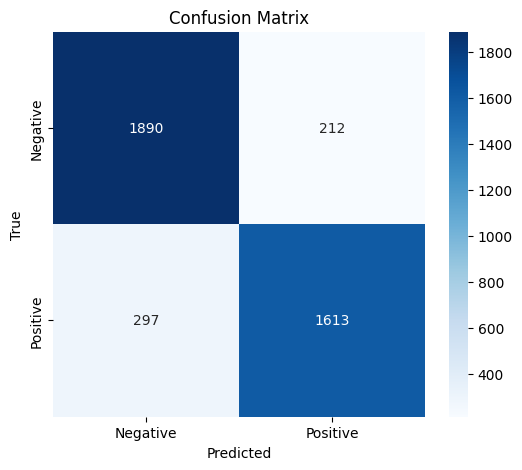

In [18]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# Cell 9: Save and Download Model
import shutil
from google.colab import files

# 1. Define the folder name where the model will be saved
save_directory = "my_sentiment_model"

print(f"Saving model and tokenizer to '{save_directory}'...")

# 2. Save the model and tokenizer files to the Colab disk
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

# 3. Zip the folder (easier to download one file than many)
print("Zipping the folder...")
shutil.make_archive(save_directory, 'zip', save_directory)

# 4. Trigger the download to your local computer
print("Downloading started...")
files.download(f"{save_directory}.zip")

Saving model and tokenizer to 'my_sentiment_model'...
Zipping the folder...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>